### Environement Setup

##### Imports

In [3]:
from pathlib import Path
import time
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from PIL import Image
import numpy as np
import plotly.graph_objs as go
import random
import colorsys
from torch.utils.data import Dataset
import torch
import io

import DatasetFunctions

In [4]:
import sys
import os

# Step 1: Add the 'f1' directory to sys.path
path_to_deploy = os.path.abspath(os.path.join(os.getcwd(), '..', 'deploy'))
sys.path.append(path_to_deploy)

# Step 2: Import the module
import Perception

# Step 3: Reset sys.path to its original state
if path_to_deploy in sys.path:
    sys.path.remove(path_to_deploy)

### Data Setup

[WindowsPath('VisionData/Trial_0'), WindowsPath('VisionData/Trial_1'), WindowsPath('VisionData/Trial_2'), WindowsPath('VisionData/Trial_3'), WindowsPath('VisionData/Trial_4'), WindowsPath('VisionData/Trial_5')]


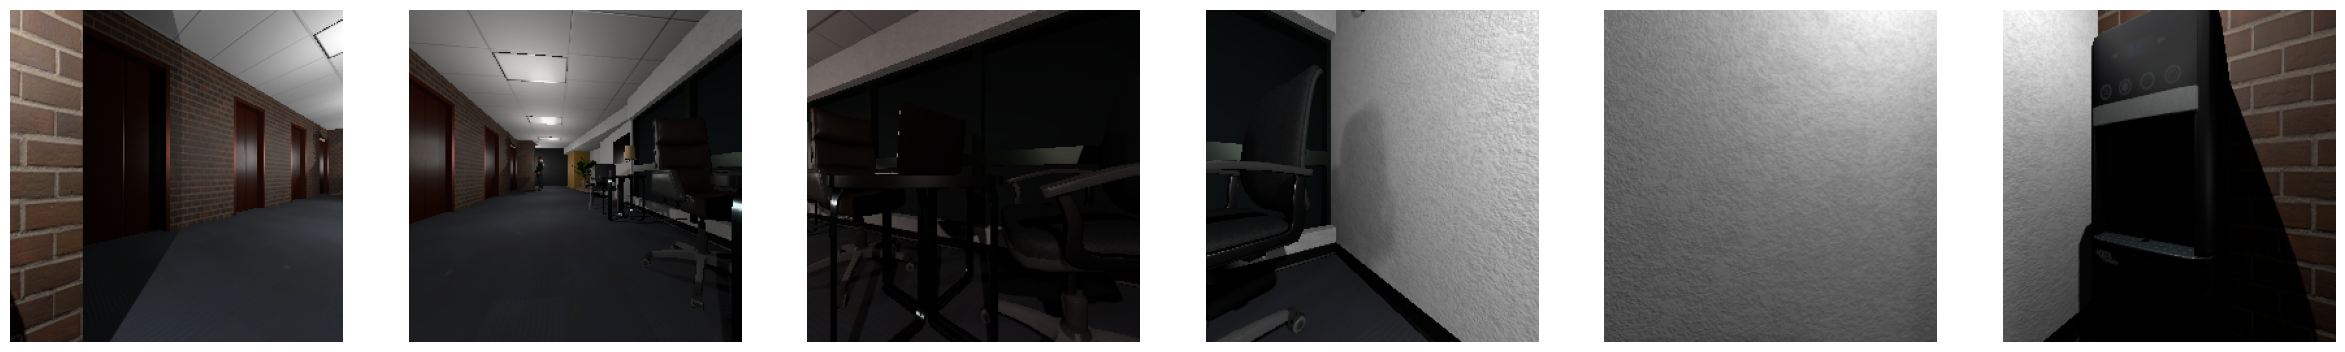

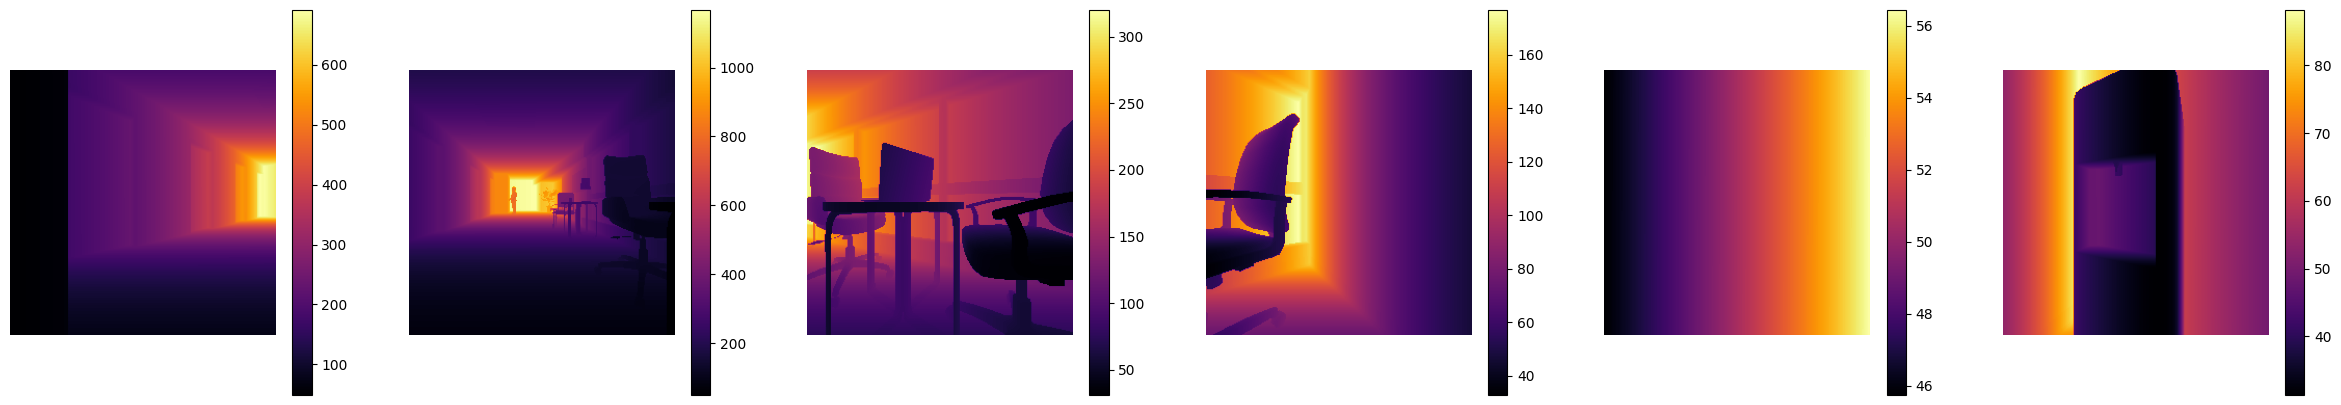

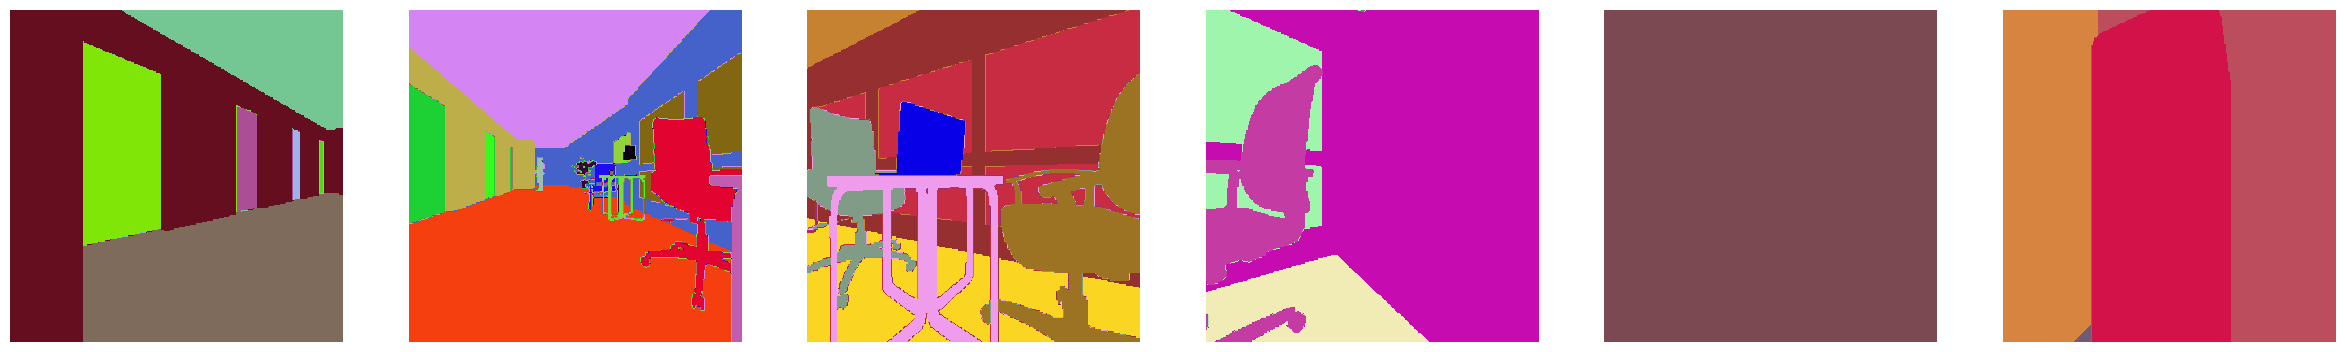

In [5]:
class CustomStreamingDataset(Dataset):
    def __init__(self, image_paths, depth_paths, segmentation_paths, image_size, index_map=None):
        self.image_paths = image_paths
        self.depth_paths = depth_paths
        self.segmentation_paths = segmentation_paths
        self.image_size = image_size
        
        image_counts = [DatasetFunctions.getFileDataLen(file_name, image_size, 3, np.uint8) for file_name in image_paths]
        segmentation_counts = [DatasetFunctions.getFileDataLen(file_name, image_size, 1, np.float32) for file_name in segmentation_paths]
        depth_counts = [DatasetFunctions.getFileDataLen(file_name, image_size, 1, np.float32) for file_name in depth_paths]
        self.len = [min(a, b, c) for a, b, c in zip(image_counts, depth_counts, segmentation_counts)]

        self.index_map=index_map

    def __len__(self):
        if self.index_map == None:
            return sum(self.len)
        else:
            return len(self.index_map)

    def __getitem__(self, index):
        if self.index_map != None:
            index = self.index_map[index]

        # Initialize the starting index of the first file
        start = 0
        # Iterate through each length in the list
        for i, length in enumerate(self.len):
            # Calculate the end index for the current file
            end = start + length
            
            # Check if the index falls within the current file range
            if start <= index < end:
                # Calculate the local index within the file
                local_index = index - start
                file_index=i
                break
            
            # Update the start index for the next file
            start = end

        image = Image.fromarray(DatasetFunctions.readFileData(self.image_paths[file_index], local_index, self.image_size, 3, np.uint8))
        depth = DatasetFunctions.readFileData(self.depth_paths[file_index], local_index, self.image_size, 1, np.float32)
        segmentation = DatasetFunctions.readFileData(self.segmentation_paths[file_index], local_index, self.image_size, 1, np.float32).reshape(self.image_size, self.image_size, 1)

        return{ 'image': image, 'depth': depth, 'segmentation': segmentation }
    

image_file = "Camera_Images.bin"
depth_file = "Camera_Depths.bin"
segmentation_file = "Camera_Segmentation.bin"
image_size = 256
image_files = []
depth_files = []
segmentation_files = []

directory_path = Path("VisionData")
directories = [d for d in directory_path.iterdir() if d.is_dir()]
print(directories)
for directory in directories:
    image_files.append(str(directory)+"\\"+image_file)
    depth_files.append(str(directory)+"\\"+depth_file)
    segmentation_files.append(str(directory)+"\\"+segmentation_file)

dataset = CustomStreamingDataset(image_files, depth_files, segmentation_files, image_size)

samples = [dataset[index] for index in range(6)]
images = [sample['image'] for sample in samples]
depths = [sample['depth'] for sample in samples]
segmentations = [sample['segmentation'] for sample in samples]


DatasetFunctions.display_images_horizontally(images)
DatasetFunctions.display_depths_horizontally(depths)
DatasetFunctions.display_segmentations_horizontally(segmentations)

### 3D Reconstruction Testing

In [6]:
percieve = Perception.PerceptionPipe(depth_processor_path = "Models\\Depth", 
                                    depth_model_path = "Models\\Depth\\results\\checkpoint-81", 
                                    segmentation_processor_path = "Models\\Segmentation", 
                                    segmentation_model_path = "Models\\Segmentation\\results\\checkpoint-324", 
                                    camera_params_path = "calibration_data.npz",
                                    camera_transforms_path = "camera_setup.txt",
                                    device='cuda')


test_depths = torch.tensor(np.squeeze(np.array(depths))) / 100 #get batch
batch_world_points = percieve.depth_to_3d_batch(test_depths.to('cuda')) #test batch
world_points = batch_world_points[1].to('cpu') #choose just one sample for visualization

# Flatten the data
x = world_points[..., 0].flatten()
y = world_points[..., 1].flatten()
z = world_points[..., 2].flatten()

# Get the ranges for x, y, z
x_min, x_max = x.min().item(), x.max().item()  # Convert to scalar
y_min, y_max = y.min().item(), y.max().item()  # Convert to scalar
z_min, z_max = z.min().item(), z.max().item()  # Convert to scalar

# Calculate the ranges
x_range = x_max - x_min
y_range = y_max - y_min
z_range = z_max - z_min

# Find the maximum range
max_range = max(x_range, y_range, z_range)

# Adjust x, y, and z ranges to match the maximum range
if x_range < max_range:
    adjustment = (max_range - x_range) / 2
    x_min -= adjustment
    x_max += adjustment

if y_range < max_range:
    adjustment = (max_range - y_range) / 2
    y_min -= adjustment
    y_max += adjustment

if z_range < max_range:
    adjustment = (max_range - z_range) / 2
    z_min -= adjustment
    z_max += adjustment

# Flatten data
x = world_points[..., 0].flatten()
y = world_points[..., 1].flatten()
z = world_points[..., 2].flatten()

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=y,
    z=z,
    mode='markers',
    marker=dict(
        size=2,
        color=z,  # Color by z value
        colorscale='Viridis',
        opacity=0.8
    )
)])

# Set axis labels and update aspect ratio
fig.update_layout(
    scene=dict(
        xaxis=dict(title='X', range=[x_min, x_max]),
        yaxis=dict(title='Y', range=[y_min, y_max]),
        zaxis=dict(title='Z', range=[z_min, z_max]),
        aspectmode='manual',  # Manual mode for custom aspect ratios
        aspectratio=dict(x=1, y=1, z=1)  # Equalize x, y, and z
    ),
    title='3D Point Cloud'
)

# Show the plot
fig.show()



(Perception Pipe) Placing models on: cuda


### Fusion Testing

C:\Users\Dylan\AppData\Local\Temp\ipykernel_26908\1154665805.py:14: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)



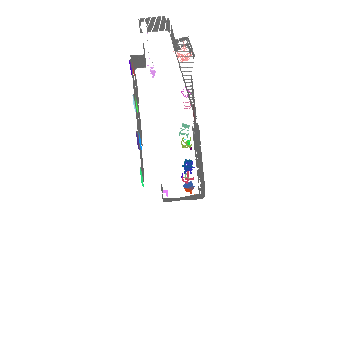

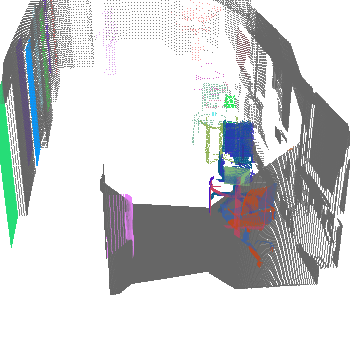

In [7]:
import pyvista as pv

id2label = DatasetFunctions.load_map_from_json_file('VisionData\\id2label.json')
label2id = percieve.segmentation_model.config.label2id
id2id = {id_: label2id[label] for id_, label in id2label.items()}
labels = []
for segment in segmentations:
    label_set = []
    ids = np.unique(segment)
    for id in ids:
        label_set.append({'id': id, 'label_id': id2id[id]})
    labels.append(label_set)

detections = percieve.fuse(torch.tensor(np.array(images)).to('cpu'), torch.tensor(segmentations).to('cpu'), batch_world_points.to('cpu'), labels)# TODO


# Initialize empty lists for all world points and their corresponding colors
all_x, all_y, all_z = [], [], []
all_marker_colors = []

labels_to_skip = 118, 22, 122, -1  # ignoring -1 for null, 118 for ceiling, 22 for zebra (i used as null during training)
color_dict = {
    115: (0.4, 0.4, 0.4),  # window
    #122: (0.5, 0.25, 0.1),  # floor
    131: (0.4, 0.4, 0.4), # wall
    109: (0.4, 0.4, 0.4) # wall brick
    # Add more labels and their corresponding colors as needed
}

# Loop through all detections
for detection in detections:
    world_points = detection.world_points.to('cpu').numpy()  # Convert to numpy array
    colors = detection.colors  # Assuming this is numpy array of RGB values
    label = detection.label

    if label in labels_to_skip:
        continue
    if label == 0:
        #print(detection.world_points)
        pass
    # Generate a random color hue for this detection
    # TODO check if label is in the dictionary, if so use that color, else do the random_hue
    if label in color_dict:
        rgb_color = color_dict[label]  # Use predefined color
    else:
        rgb_color = (random.random(), random.random(), random.random())
    
    # Assign color to all points in this detection
    detection_color = np.tile(rgb_color, (world_points.shape[0], 1))  # Repeat RGB for each point
    
    # Flatten world points
    x = world_points[..., 0].flatten()
    y = world_points[..., 1].flatten()
    z = world_points[..., 2].flatten()

    # Append the points and colors to global lists
    all_x.append(x)
    all_y.append(y)
    all_z.append(z)
    all_marker_colors.append(detection_color)

# Concatenate all detections into one array
all_x = np.concatenate(all_x)
all_y = np.concatenate(all_y)
all_z = np.concatenate(all_z)
all_marker_colors = np.concatenate(all_marker_colors)

if np.max(all_marker_colors) > 1.0:
    all_marker_colors = all_marker_colors / 255.0
point_cloud = np.column_stack((all_x, all_y, all_z))
plotter = pv.Plotter()
plotter.add_points(point_cloud, scalars=all_marker_colors, rgb=True, point_size=1.4, opacity=0.8)

# Set camera position, focal point, and view up vector
plotter.camera.position = [0, -45.5, -7.5]  # Camera position
plotter.camera.focal_point = [0, 0, 1]          # Point to look at
plotter.camera.viewup = [0, 1, 0]               # Defines which direction is up

# Optional: You can also adjust the camera's view angle if needed
plotter.camera.view_angle = 30  # Adjust view angle (in degrees)

# Render the scene to an image
custom_size = (350, 350)  # Example size, change as needed
plotter.window_size = custom_size  # Set the window size
image = plotter.screenshot()     # Take a screenshot

# Convert to PIL Image
pil_image = Image.fromarray(image)
display(pil_image)

# Set camera position, focal point, and view up vector
plotter.camera.position = [0, -4.5, -7.5]  # Camera position
plotter.camera.focal_point = [0, 0, 2]          # Point to look at
plotter.camera.viewup = [0, 1, 0]               # Defines which direction is up

# Optional: You can also adjust the camera's view angle if needed
plotter.camera.view_angle = 30  # Adjust view angle (in degrees)
plotter.render()
image = plotter.screenshot()     # Take a screenshot
pil_image = Image.fromarray(image)
display(pil_image)

### Speed Testing

(Perception Pipe) Placing models on: cuda
(Perception Pipe) Placing models on: cpu


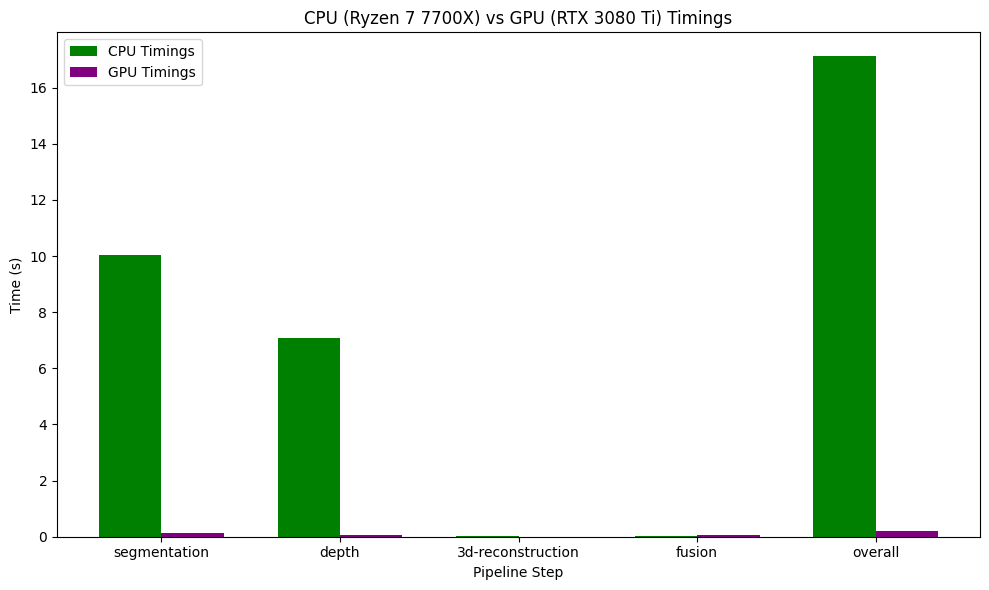

                     segmentation     depth  3d-reconstruction    fusion  \
CPU (Ryzen 7 7700X)     10.019785  7.062734           0.014725  0.015365   
GPU (RTX 3080 Ti)        0.117861  0.046174           0.000646  0.053710   

                       overall  
CPU (Ryzen 7 7700X)  17.112824  
GPU (RTX 3080 Ti)     0.218495  


In [4]:
test_images = images
#del(percieve)
# print("Wait for 15 seconds... (letting python warm up)")
# time.sleep(15)  # Wait for 15 seconds
# print("Done waiting!")

percieve = Perception.PerceptionPipe(depth_processor_path = "Models\\Depth", 
                                    depth_model_path = "Models\\Depth\\results\\checkpoint-81", 
                                    segmentation_processor_path = "Models\\Segmentation", 
                                    segmentation_model_path = "Models\\Segmentation\\results\\checkpoint-324", 
                                    camera_params_path = "calibration_data.npz",
                                    camera_transforms_path = "camera_setup.txt",
                                    device='cuda')

data, gpu_timings = percieve(test_images) #warmup run
del data
torch.cuda.empty_cache()
data, gpu_timings = percieve(test_images) #warmup run
del data
torch.cuda.empty_cache()
data, gpu_timings = percieve(test_images) #warmup run
del data
torch.cuda.empty_cache()
gpu_start = time.perf_counter()
data, gpu_timings = percieve(test_images)
gpu_end = time.perf_counter()
gpu_timings['overall']=gpu_end-gpu_start
del(percieve)

percieve = Perception.PerceptionPipe(depth_processor_path = "Models\\Depth", 
                                    depth_model_path = "Models\\Depth\\results\\checkpoint-81", 
                                    segmentation_processor_path = "Models\\Segmentation", 
                                    segmentation_model_path = "Models\\Segmentation\\results\\checkpoint-324", 
                                    camera_params_path = "calibration_data.npz",
                                    camera_transforms_path = "camera_setup.txt",
                                    device='cpu')
cpu_start = time.perf_counter()
data, cpu_timings = percieve(test_images)
cpu_end = time.perf_counter()
cpu_timings['overall']=cpu_end-cpu_start



# Extract keys and values
keys = list(cpu_timings.keys())  # Both dictionaries have the same keys
values1 = list(cpu_timings.values())
values2 = list(gpu_timings.values())

# Define the bar width and positions
bar_width = 0.35
x = np.arange(len(keys))

# Create the plot
plt.figure(figsize=(10, 6))

# Plot bars for the first dictionary
plt.bar(x - bar_width/2, values1, width=bar_width, label='CPU Timings', color='green')

# Plot bars for the second dictionary
plt.bar(x + bar_width/2, values2, width=bar_width, label='GPU Timings', color='purple')

# Add labels and title
plt.xlabel('Pipeline Step')
plt.ylabel('Time (s)')
plt.title('CPU (Ryzen 7 7700X) vs GPU (RTX 3080 Ti) Timings')
plt.xticks(x, keys)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()



# Create a DataFrame from the dictionaries
df = pd.DataFrame({'CPU (Ryzen 7 7700X)': cpu_timings, 'GPU (RTX 3080 Ti)': gpu_timings})
# Transpose the DataFrame to have keys as the index
df = df.T
# Display the DataFrame as a table
print(df)